### Улучшение baseline-модели

Этапы проекта:

- Этап 1 - Подготовка среды MLflow - shell скрипт и регистрация базовой модели.

- Этап 2 - Исследовательский Анализ Данных (EDA).

- Этап 3 - Генерация Признаков и Обучение Модели.

- Этап 4 - Отбор Признаков и Обучение Модели.

- Этап 5 - Подбор Гиперпараметров и Обучение Финальной Версии Модели.


Данные в таблице real_estate_clean:
- id — ID квартиры,
- building_id — ID дома, в котором находится квартира,
- build_year — год постройки,
- building_type_int — тип здания,
- latitude — широта, на которой находится дом,
- longitude — долгота, на которой находится дом,
- ceiling_height — высота потолков в здании,
- flats_count — общее количество квартир,
- floors_total — общее количество этажей,
- has_elevator — наличие лифта,
- floor — этаж, на котором находится квартира,
- kitchen_area — площадь кухни,
- living_area — площадь гостиной,
- rooms — количество комнат,
- is_apartment — является ли квартира апартаментами,
- studio — является ли квартира студией,
- total_area — общая площадь квартиры,
- target — цена квартиры.

In [173]:
import seaborn as sns
import json
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import optuna
import os
import pandas as pd
import psycopg
import psycopg2 as psycopg
import folium

from autofeat import AutoFeatRegressor
from catboost import CatBoostRegressor
from category_encoders import CatBoostEncoder
from collections import defaultdict
from geopy.distance import great_circle
from optuna.integration.mlflow import MLflowCallback
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import (
    OneHotEncoder, 
    StandardScaler,
    PolynomialFeatures,
    KBinsDiscretizer,
)


import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 100)

np.random.seed(42)


In [174]:
# Пути и названия файлов заданы в виде параметров
PATH_DATA = '../data'

DATA_FILE = 'initial_data.csv'
DATA_FILE_X_TRAIN = 'x_train.csv'
DATA_FILE_Y_TRAIN = 'y_train.csv'
DATA_FILE_X_TEST = 'x_test.csv'
DATA_FILE_Y_TEST = 'y_test.csv'

PATH_MODELS = '../models'
MODEL_FILE = 'base_model.pkl'

RESULTS_DIR = '../results'
RESULTS_FILE = 'cv_res.json'
RESULTS_FILE_TEST = 'test_res.json'

ASSETS_DIR = '../asserts'
FS_ASSETS = '../fs_assets'
OP_ASSETS = '../optuna_assets'

In [94]:
# Другие параметры
TABLE_NAME = 'real_estate_clean'

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = 'real_estate_project_#2'
RUN_NAME = 'base_model'
REGISTRY_MODEL_NAME = "real_estate_model_base"

RANDOM_STATE = 42

#### Этап 1: Регистрация базовой модели

In [3]:
# Загрузка данных
connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.getenv("DB_DESTINATION_HOST"),
    "port": os.getenv("DB_DESTINATION_PORT"),
    "dbname": os.getenv("DB_DESTINATION_NAME"),
    "user": os.getenv("DB_DESTINATION_USER"),
    "password": os.getenv("DB_DESTINATION_PASSWORD"),
}
assert all([var_value != "" for var_value in list(postgres_credentials.values())])

connection.update(postgres_credentials)

with psycopg.connect(**connection) as conn:

# создаёт объект курсора для выполнения запросов к базе данных
# с помощью метода execute() выполняется SQL-запрос для выборки данных из таблицы TABLE_NAME
    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
                
        # извлекаем все строки, полученные в результате выполнения запроса
        data = cur.fetchall()

        # получает список имён столбцов из объекта курсора
        columns = [col[0] for col in cur.description]


df = pd.DataFrame(data, columns=columns) 

In [4]:
# Исходные данные
df.head(2)

,id,building_id,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator,floor,is_apartment,kitchen_area,living_area,rooms,studio,total_area,target
0,0,6220,1965,6,55.717113,37.781120,2.64,84,12,true,9,false,9.9,19.9,1,false,35.099998,9500000
1,1,18012,2001,2,55.794849,37.608013,3.00,97,10,true,7,false,0.0,16.6,1,false,43.000000,13500000


Данные будем делить на тренировочный и тестовый набор. Предполагается использовать кросс-валидацию, для получения лучшей обобщающей способности модели.

In [96]:
df['building_type_int'] = df['building_type_int'].astype('object')

# Разделим датасет на тейн и тест
X = df.drop(['target', 'id', 'building_id'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
        X, y, shuffle=True, test_size=0.25, random_state=RANDOM_STATE)

print(f'Размер тренировочного набора: {X_train.shape}, {y_train.shape}')
print(f'Размер тестового набора: {X_test.shape}, {y_test.shape}')

Размер тренировочного набора: (77619, 15), (77619,)
Размер тестового набора: (25874, 15), (25874,)


Поскольку я не знаю, как грузить модели из разных окружений вирутальной машины, обучим ее заново со старыми параметрами.

In [97]:
# Трансформируем данные
cat_features = X_train.select_dtypes(include='object')
# Выберем бинарные признаки
potential_binary_features = cat_features.nunique() == 2

binary_cat_features = cat_features[potential_binary_features[potential_binary_features].index]
other_cat_features = cat_features[potential_binary_features[~potential_binary_features].index]
num_features = X_train.select_dtypes(['float', 'int'])

preprocessor = ColumnTransformer(
        [
    ('binary', OneHotEncoder(drop='if_binary'), binary_cat_features.columns.tolist()),
    ('cat', CatBoostEncoder(return_df=False), other_cat_features.columns.tolist()),
    ('num', StandardScaler(), num_features.columns.tolist())
        ],
    remainder='drop',
    verbose_feature_names_out=False
    )

model_base = CatBoostRegressor(n_estimators=1000,
                              random_seed=42,
                              verbose=False,
                              loss_function='RMSE')

pipeline = Pipeline(
        [
        ('preprocessor', preprocessor),
        ('model', model_base)
        ]
    )
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('binary',
                                                  OneHotEncoder(drop='if_binary'),
                                                  []),
                                                 ('cat',
                                                  CatBoostEncoder(return_df=False),
                                                  ['building_type_int']),
                                                 ('num', StandardScaler(),
                                                  ['build_year', 'latitude',
                                                   'longitude',
                                                   'ceiling_height',
                                                   'flats_count',
                                                   'floors_total', 'floor',
                                                   'kitchen_area',
                                                   'living_area', 'rooms',
                                                   'total_area'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7f4955f01720>)])

In [98]:
y_pred = pipeline.predict(X_test)
res_test = root_mean_squared_error(y_test, y_pred)
print(f'Результат на тестовой выборке, RMSE: {round(res_test, 3)}')

Результат на тестовой выборке, RMSE: 2381764.919


In [99]:
# Получим результат при обучении с кросс-валидацией
cv_strategy = StratifiedKFold(n_splits=3)
cv_res = cross_validate(
        pipeline,
        X_train,
        y_train,
        cv=cv_strategy,
        n_jobs=-1,
        scoring='neg_root_mean_squared_error'
        )
for key, value in cv_res.items():
        cv_res[key] = round(value.mean(), 3)

print(f'Результат при кросс-валидации, RMSE: {abs(cv_res[key])}')

Результат при кросс-валидации, RMSE: 2404247.696


In [100]:
model_base.get_params()

{'loss_function': 'RMSE',
 'random_seed': 42,
 'verbose': False,
 'n_estimators': 1000}

In [101]:
# Сохраним результат теста
with open(f'{RESULTS_DIR}/{RESULTS_FILE_TEST}', 'w') as f:
    json.dump(res_test, f)

In [102]:
# Сохраним результат кросс-валидации
with open(f'{RESULTS_DIR}/{RESULTS_FILE}', 'w') as f:
    json.dump(cv_res, f)

In [103]:
# Сохраним разделенные датасеты
X_train.to_csv(f'{PATH_DATA}/{DATA_FILE_X_TRAIN}', index=None)
y_train.to_csv(f'{PATH_DATA}/{DATA_FILE_Y_TRAIN}', index=None)
X_test.to_csv(f'{PATH_DATA}/{DATA_FILE_X_TEST}', index=None)
y_test.to_csv(f'{PATH_DATA}/{DATA_FILE_Y_TEST}', index=None)

# Сохраним исходный датасет
df.to_csv(f'{PATH_DATA}/{DATA_FILE}', index=None)

Далее залогируем исходные данные, модель и метрики.

In [104]:
cb_params = {'model__loss_function': 'RMSE',
             'model__random_seed': 42,
             'model__verbose': False,
             'model__n_estimators': 1000}

res_test = {'RMSE_test': res_test}

In [105]:
RUN_NAME

'base_model'

In [106]:
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" 
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") 
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")


mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

# настройки для логирования в MLFlow
pip_requirements = '../requirements.txt'
signature = mlflow.models.infer_signature(X_test, y_pred)
input_example = X_test[:10]

# В первый раз создадим эксперимент
#experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    
    mlflow.log_metrics(cv_res)
    mlflow.log_metrics(res_test)
    mlflow.log_params(cb_params)

    model_info = mlflow.sklearn.log_model( 
        sk_model=pipeline,
        artifact_path="models",
        registered_model_name=REGISTRY_MODEL_NAME,
        signature=signature,
        input_example=input_example,
        await_registration_for=60,
        pip_requirements=pip_requirements)

Registered model 'real_estate_model_base' already exists. Creating a new version of this model...
2024/11/02 18:33:03 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: real_estate_model_base, version 8
Created version '8' of model 'real_estate_model_base'.


In [ ]:
# run_id с сохраненными артефактами базовой модели
run_id_base = '8b91287baec948ed8f4494d858abf36c'

#### Этап 2: Исследовательский Анализ Данных (EDA)

План этапа:
- Понимание данных: Первоначально ознакомьтесь с данными, изучите типы данных, проверьте наличие пропущенных значений.
- Визуализация данных: Используйте графики и диаграммы для визуализации распределений признаков и возможных взаимосвязей между ними.
- Статистический анализ: Примените статистические методы для изучения центральных тенденций, разброса и корреляций между признаками.
- Предварительные выводы: На основе проведённого анализа сформулируйте предварительные выводы о данных, которые помогут в дальнейшем этапе моделирования.


In [4]:
# Загрузка данных
df = pd.read_csv('../data/initial_data.csv', index_col=False)

In [5]:
# Общий обзор датасета
df.head(3)

,id,building_id,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator,floor,is_apartment,kitchen_area,living_area,rooms,studio,total_area,target
0,0,6220,1965,6,55.717113,37.781120,2.64,84,12,True,9,False,9.9,19.9,1,False,35.099998,9500000
1,1,18012,2001,2,55.794849,37.608013,3.00,97,10,True,7,False,0.0,16.6,1,False,43.000000,13500000
2,2,17821,2000,4,55.740040,37.761742,2.70,80,10,True,9,False,9.0,32.0,2,False,56.000000,13500000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103493 entries, 0 to 103492
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 103493 non-null  int64  
 1   building_id        103493 non-null  int64  
 2   build_year         103493 non-null  int64  
 3   building_type_int  103493 non-null  int64  
 4   latitude           103493 non-null  float64
 5   longitude          103493 non-null  float64
 6   ceiling_height     103493 non-null  float64
 7   flats_count        103493 non-null  int64  
 8   floors_total       103493 non-null  int64  
 9   has_elevator       103493 non-null  bool   
 10  floor              103493 non-null  int64  
 11  is_apartment       103493 non-null  bool   
 12  kitchen_area       103493 non-null  float64
 13  living_area        103493 non-null  float64
 14  rooms              103493 non-null  int64  
 15  studio             103493 non-null  bool   
 16  to

В данных нет пропусков. Есть категориальные, числовые и булевые признаки.

In [10]:
df.describe()

,id,building_id,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,floor,kitchen_area,living_area,rooms,total_area,target
count,103493.000000,103493.000000,103493.000000,103493.000000,103493.000000,103493.000000,103493.000000,103493.000000,103493.000000,103493.000000,103493.000000,103493.000000,103493.000000,103493.000000,1.034930e+05
mean,68546.243253,13171.463191,1984.141314,3.523630,55.728188,37.604233,2.687509,223.001701,13.020649,6.726039,8.101251,27.533055,1.945552,51.592527,1.179991e+07
std,41104.240116,6438.634112,19.376710,1.415885,0.103325,0.148727,0.130793,133.797179,5.122506,4.508221,2.986849,14.425440,0.815831,16.222243,4.510034e+06
min,0.000000,173.000000,1912.000000,0.000000,55.427238,37.190800,2.450000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,11.000000,1.100000e+01
25%,32623.000000,8161.000000,1969.000000,4.000000,55.648724,37.496128,2.640000,111.000000,9.000000,3.000000,6.000000,19.000000,1.000000,38.400002,8.500000e+06
50%,67293.000000,12819.000000,1979.000000,4.000000,55.717560,37.591682,2.640000,192.000000,12.000000,6.000000,8.400000,28.400000,2.000000,48.000000,1.080000e+07
75%,103651.000000,18529.000000,2002.000000,4.000000,55.813778,37.722462,2.700000,300.000000,17.000000,9.000000,10.000000,36.000000,3.000000,60.400002,1.400000e+07
max,141361.000000,24620.000000,2023.000000,6.000000,56.011032,37.946411,3.000000,640.000000,29.000000,20.000000,16.300000,74.000000,5.000000,120.300003,2.872000e+07


Выбросы удалены на этапе очистки данных.

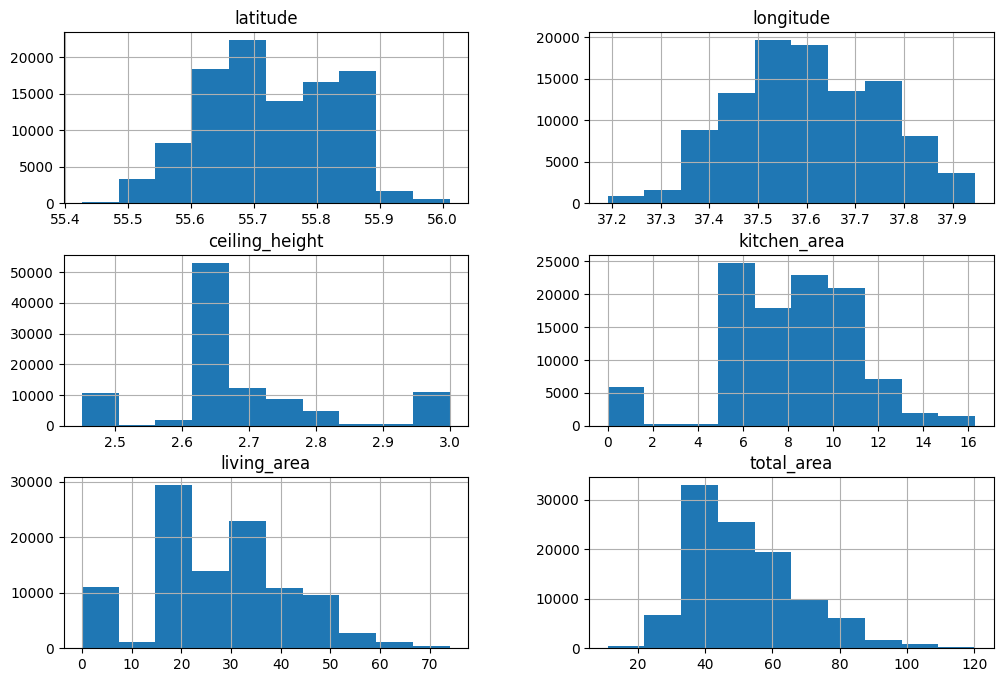

In [47]:
# Анализ признаков для модели
df.select_dtypes('float').hist(figsize=(12,8));

plt.savefig(os.path.join(ASSETS_DIR, 'int_float_features_distribution'))

Числовые данные в соновном распределены нормально. Есть часть строк, где параметр площадь кухни состаляет 0.

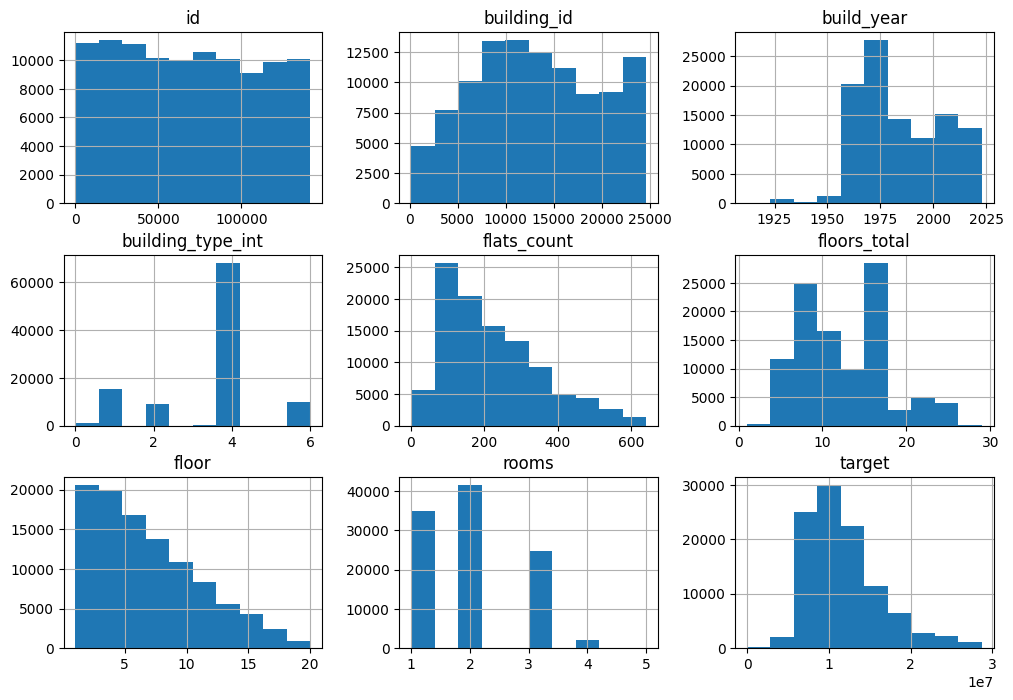

In [46]:
df.select_dtypes('int').hist(figsize=(12,8));

plt.savefig(os.path.join(ASSETS_DIR, 'int_hist_features_distribution'))

id и building_id - индексы, от них необходимо будет избавиться.

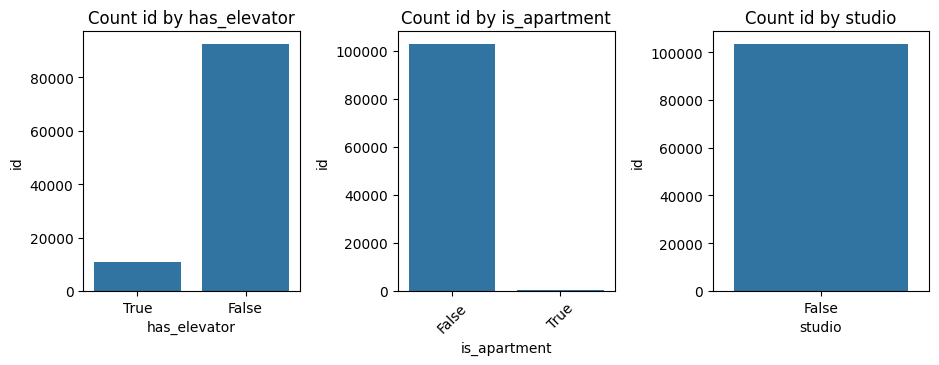

In [45]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(10, 4, forward=True)
fig.tight_layout(pad=4)


x = "has_elevator"
y = "id"
stat = ["count"]
agg_df = df.groupby(x).agg({y: 'count'}).reset_index()
sns.barplot(agg_df, x=x, y=y, ax=axs[0])
axs[0].set_title(f'Count {y} by {x}')
axs[0].set_xticklabels(df[x].unique(), rotation = 0);

x = "is_apartment"
y = "id"
stat = ["count"]
agg_df = df.groupby(x).agg({y: 'count'}).reset_index()
sns.barplot(agg_df, x=x, y=y, ax=axs[1])
axs[1].set_title(f'Count {y} by {x}')
axs[1].set_xticklabels(df[x].unique(), rotation = 45);

x = "studio"
y = "id"
stat = ["count"]
agg_df = df.groupby(x).agg({y: 'count'}).reset_index()
sns.barplot(agg_df, x=x, y=y, ax=axs[2])
axs[2].set_title(f'Count {y} by {x}')
axs[2].set_xticklabels(df[x].unique(), rotation = 0);


plt.savefig(os.path.join(ASSETS_DIR, 'bool_features_in_initial_dataframe'))

Столбцы is_apartment и studio содержат по одному значению, необходимо от них избавиться.

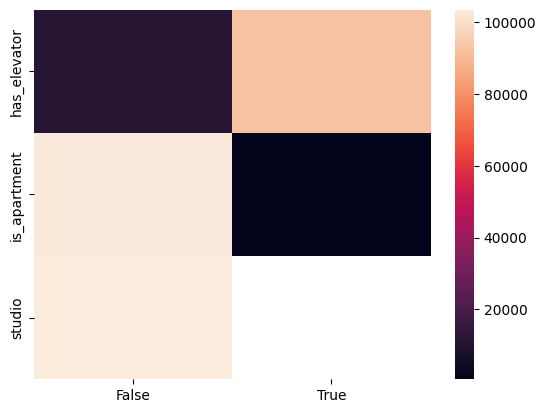

In [63]:
x = "id"
binary_columns = [
    "has_elevator", 
    "is_apartment", 
    "studio"
]

heat_df = df[binary_columns].apply(pd.Series.value_counts).T
sns.heatmap(heat_df)

plt.savefig(os.path.join(ASSETS_DIR, 'bool_features_heatmap'))

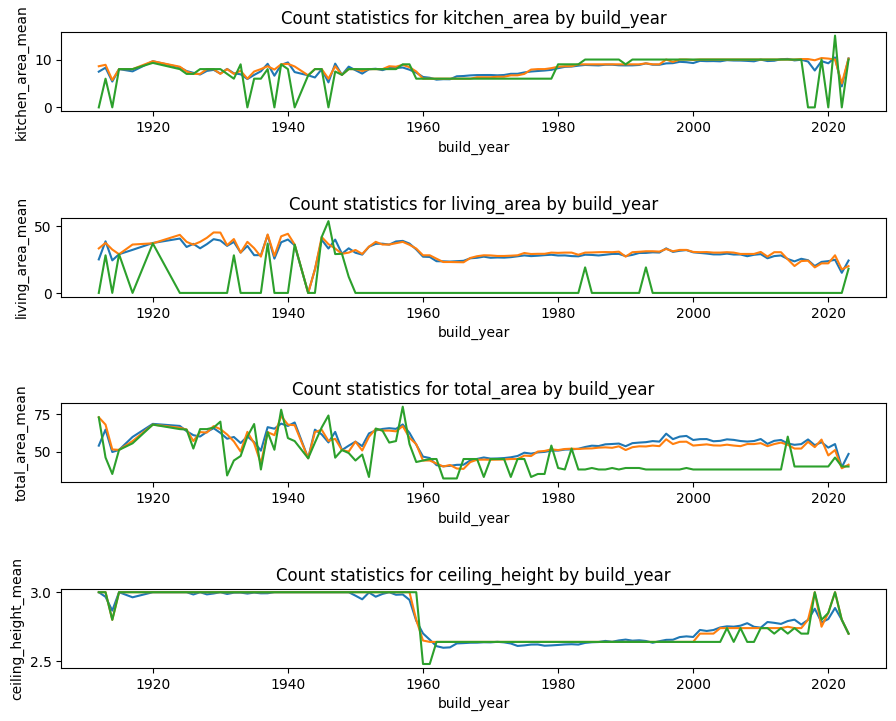

In [13]:
# инициализация переменной для названия колонки
x = "build_year"

# список колонок, для которых будут вычисляться статистики
charges_columns = [
     'kitchen_area','living_area','total_area', 'ceiling_height'
]

# удаление пустых колонок для посчёта медианного значения
df[charges_columns].dropna(inplace=True)

# список статистик, которые будут вычисляться для каждой группы
stats = ["mean", "median", lambda x: x.mode().iloc[0]]  # среднее значение, медиана и мода

# группировка данных по дате начала и агрегация статистик 
kitchen_area_agg = df[[x] + [charges_columns[0]]].groupby([x]).agg(stats).reset_index()
# удаление верхнего уровня индекса колонок (после агрегации)
kitchen_area_agg.columns = kitchen_area_agg.columns.droplevel()
# переименование колонок для удобства восприятия
kitchen_area_agg.columns = [x, "kitchen_area_mean", "kitchen_area_median", "kitchen_area_mode"]

living_area_agg = df[[x] + [charges_columns[1]]].dropna().groupby([x]).agg(stats).reset_index()
living_area_agg.columns = living_area_agg.columns.droplevel()
living_area_agg.columns = [x, "living_area_mean", "living_area_median", "living_area_mode"]

total_area_agg = df[[x] + [charges_columns[2]]].dropna().groupby([x]).agg(stats).reset_index()
total_area_agg.columns = total_area_agg.columns.droplevel()
total_area_agg.columns = [x, "total_area_mean", "total_area_median", "total_area_mode"]

ceiling_height_agg = df[[x] + [charges_columns[3]]].dropna().groupby([x]).agg(stats).reset_index()
ceiling_height_agg.columns = ceiling_height_agg.columns.droplevel()
ceiling_height_agg.columns = [x, "ceiling_height_mean", "ceiling_height_median", "ceiling_height_mode"]

# создание объекта для отображения графиков
fig, axs = plt.subplots(4, 1)
# настройка отступов между графиками
fig.tight_layout(pad=2.5)
# установка размера фигуры
fig.set_size_inches(10, 8, forward=True)

# построение линейных графиков 
sns.lineplot(kitchen_area_agg, ax=axs[0], x=x, y='kitchen_area_mean')
sns.lineplot(kitchen_area_agg, ax=axs[0], x=x, y="kitchen_area_median")
sns.lineplot(kitchen_area_agg, ax=axs[0], x=x, y="kitchen_area_mode")
# установка заголовка для верхнего графика
axs[0].set_title(f"Count statistics for {charges_columns[0]} by {x}")

sns.lineplot(living_area_agg, ax=axs[1], x=x, y='living_area_mean')
sns.lineplot(living_area_agg, ax=axs[1],  x=x, y="living_area_median")
sns.lineplot(living_area_agg, ax=axs[1],  x=x, y="living_area_mode")
# установка заголовка для нижнего графика
axs[1].set_title(f"Count statistics for {charges_columns[1]} by {x}")

sns.lineplot(total_area_agg, ax=axs[2], x=x, y='total_area_mean')
sns.lineplot(total_area_agg, ax=axs[2],  x=x, y="total_area_median")
sns.lineplot(total_area_agg, ax=axs[2],  x=x, y="total_area_mode")
# установка заголовка для нижнего графика
axs[2].set_title(f"Count statistics for {charges_columns[2]} by {x}")

sns.lineplot(ceiling_height_agg, ax=axs[3], x=x, y='ceiling_height_mean')
sns.lineplot(ceiling_height_agg, ax=axs[3],  x=x, y="ceiling_height_median")
sns.lineplot(ceiling_height_agg, ax=axs[3],  x=x, y="ceiling_height_mode")

axs[3].set_title(f"Count statistics for {charges_columns[3]} by {x}")

# сохранение графика в файл
plt.savefig(os.path.join(ASSETS_DIR, 'charges_float_1_by_year'))

Из графиков выше можно отметить, что в домах постройки после 1960 года высота потолков сильно ниже.

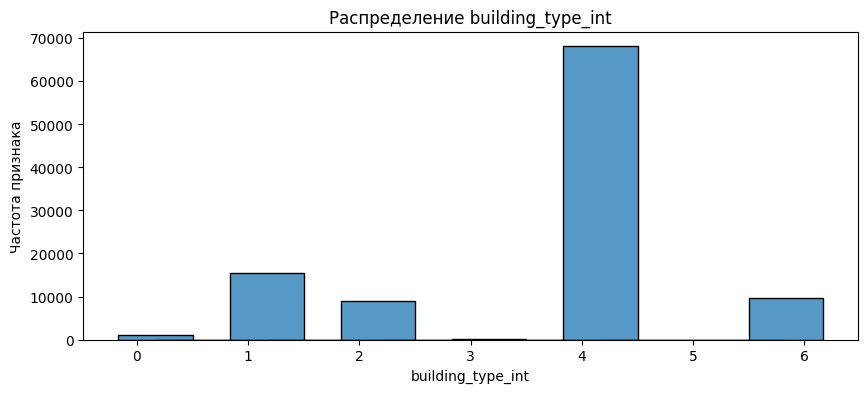

In [45]:
#зададим размер диаграммы
plt.figure(figsize=(10,4))

#зададим параметры диаграммы
sns.histplot(data=df, 
             x='building_type_int',  
             multiple='dodge', 
             shrink=2)

plt.xlabel('building_type_int')
plt.ylabel('Частота признака')
plt.title('Распределение building_type_int');

# сохранение графика в файл
plt.savefig(os.path.join(ASSETS_DIR, 'building_type_int_distribution'))

Самый многочиленный тип строения - 4.

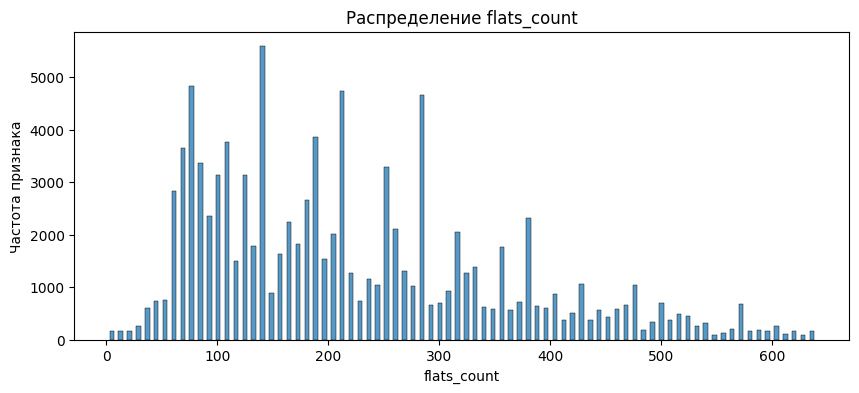

In [46]:
#зададим размер диаграммы
plt.figure(figsize=(10,4))

#зададим параметры диаграммы
sns.histplot(data=df, 
             x='flats_count',  
             multiple='dodge', 
             shrink=0.5)

plt.xlabel('flats_count')
plt.ylabel('Частота признака')
plt.title('Распределение flats_count');

# сохранение графика в файл
plt.savefig(os.path.join(ASSETS_DIR, 'flats_count_distribution'))

Чаще всего встречаются в данных встречаются дома с количеством квартир 150, 200 и около 300.

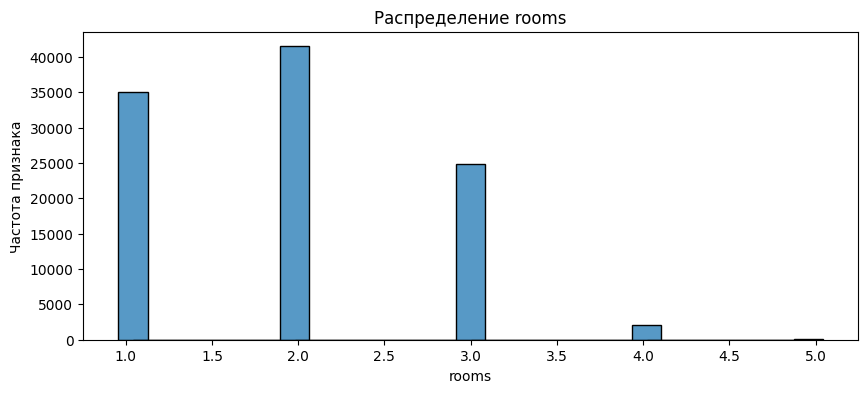

In [47]:
#зададим размер диаграммы
plt.figure(figsize=(10,4))

#зададим параметры диаграммы
sns.histplot(data=df, 
             x='rooms',  
             multiple='dodge', 
             shrink=2)

plt.xlabel('rooms')
plt.ylabel('Частота признака')
plt.title('Распределение rooms');

# сохранение графика в файл
plt.savefig(os.path.join(ASSETS_DIR, 'rooms_distribution'))

Больше всего в данных двухкомнатных квартир.

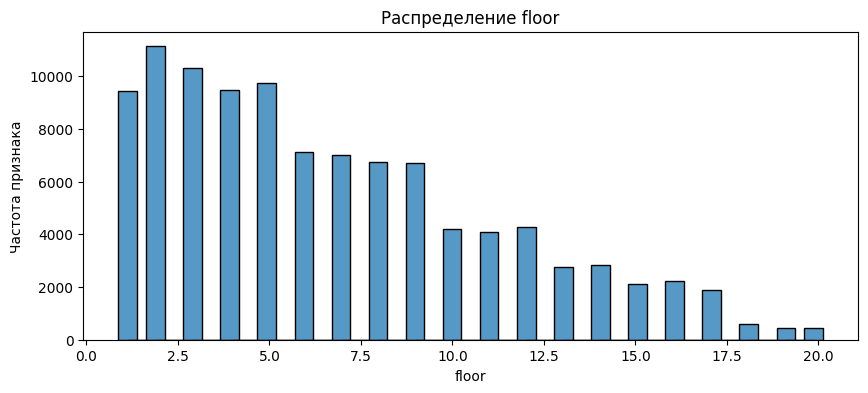

In [48]:
#зададим размер диаграммы
plt.figure(figsize=(10,4))

#зададим параметры диаграммы
sns.histplot(data=df, 
             x='floor',  
             multiple='dodge', 
             shrink=2)

plt.xlabel('floor')
plt.ylabel('Частота признака')
plt.title('Распределение floor');

# сохранение графика в файл
plt.savefig(os.path.join(ASSETS_DIR, 'floor_distribution'))

Этажность распределена равномерно.

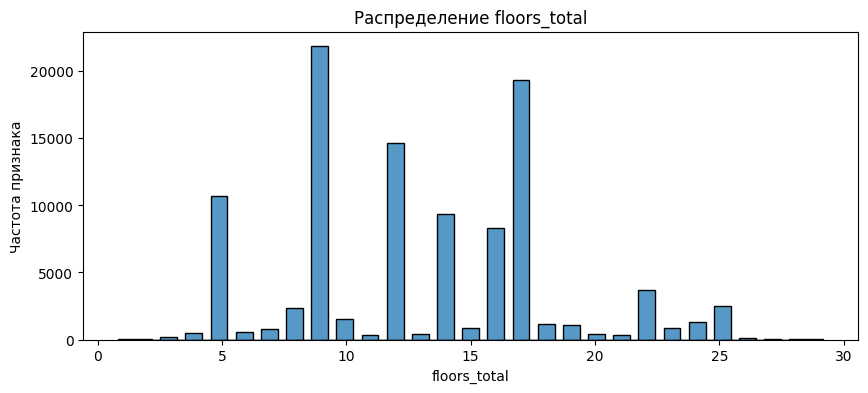

In [49]:
#зададим размер диаграммы
plt.figure(figsize=(10,4))

#зададим параметры диаграммы
sns.histplot(data=df, 
             x='floors_total',  
             multiple='dodge', 
             shrink=2)

plt.xlabel('floors_total')
plt.ylabel('Частота признака')
plt.title('Распределение floors_total');

# сохранение графика в файл
plt.savefig(os.path.join(ASSETS_DIR, 'floors_total_distribution'))

Больше всего домов с 5, 9 и 17 этажами.

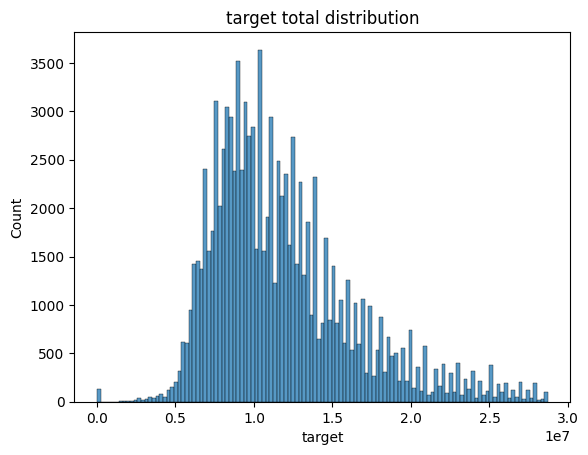

In [88]:
# Анализ целевой переменной

# установка названия колонки для агрегации
x = "target"

# создание столбчатой диаграммы для визуализации распределения целевой переменной
sns.histplot(df[x])

# установка заголовка графика
plt.title(f"{x} total distribution")

# сохранение графика в файл
plt.savefig(os.path.join(ASSETS_DIR, 'target_count'))

Целевой признак распределен равномерно. Встречаются единичные строки с нулевой ценой.

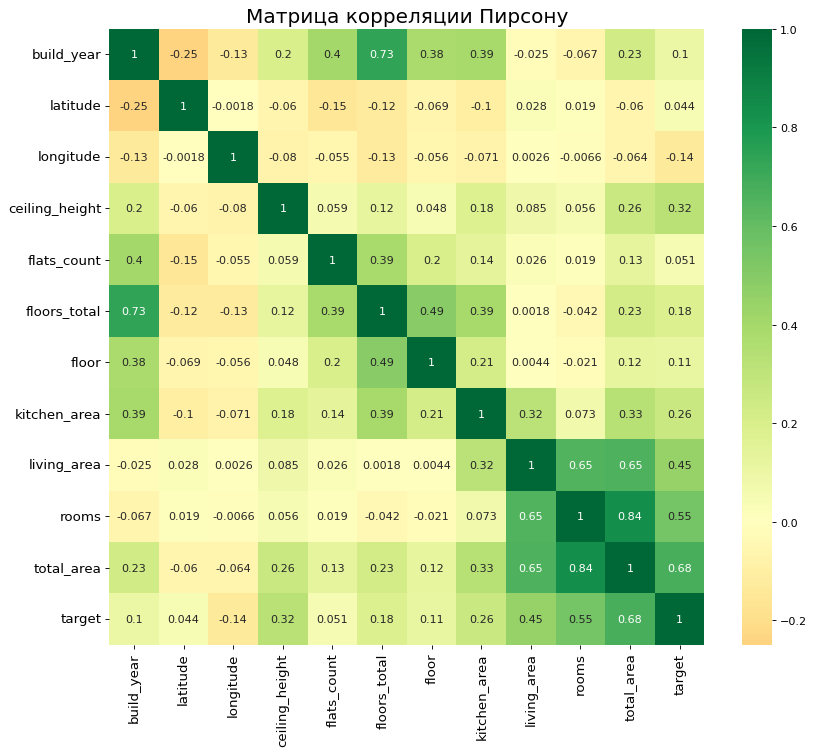

<Figure size 640x480 with 0 Axes>

In [ ]:
# Посмотрим на корреляцию численных признаков друг на друга и на целевой показатель
columns_to_show = ['build_year',
                   'latitude',
                   'longitude',
                   'ceiling_height',
                   'flats_count',
                   'floors_total',
                   'floor',
                   'kitchen_area',
                   'living_area',
                   'rooms',
                   'total_area',
                   'target']

plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(df[columns_to_show].corr(), xticklabels=df[columns_to_show].corr().columns, 
            yticklabels=df[columns_to_show].corr().columns, 
            cmap='RdYlGn', center=0, annot=True)

#выведем результат
plt.title('Матрица корреляции Пирсону', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# сохранение визуализации в файл
plt.savefig(os.path.join(ASSETS_DIR, 'feature_correlation'))

Цена квартиры сильнее всего коррелирует с площадью, количеством комнат и высотой потолков. Это логично и понятно.

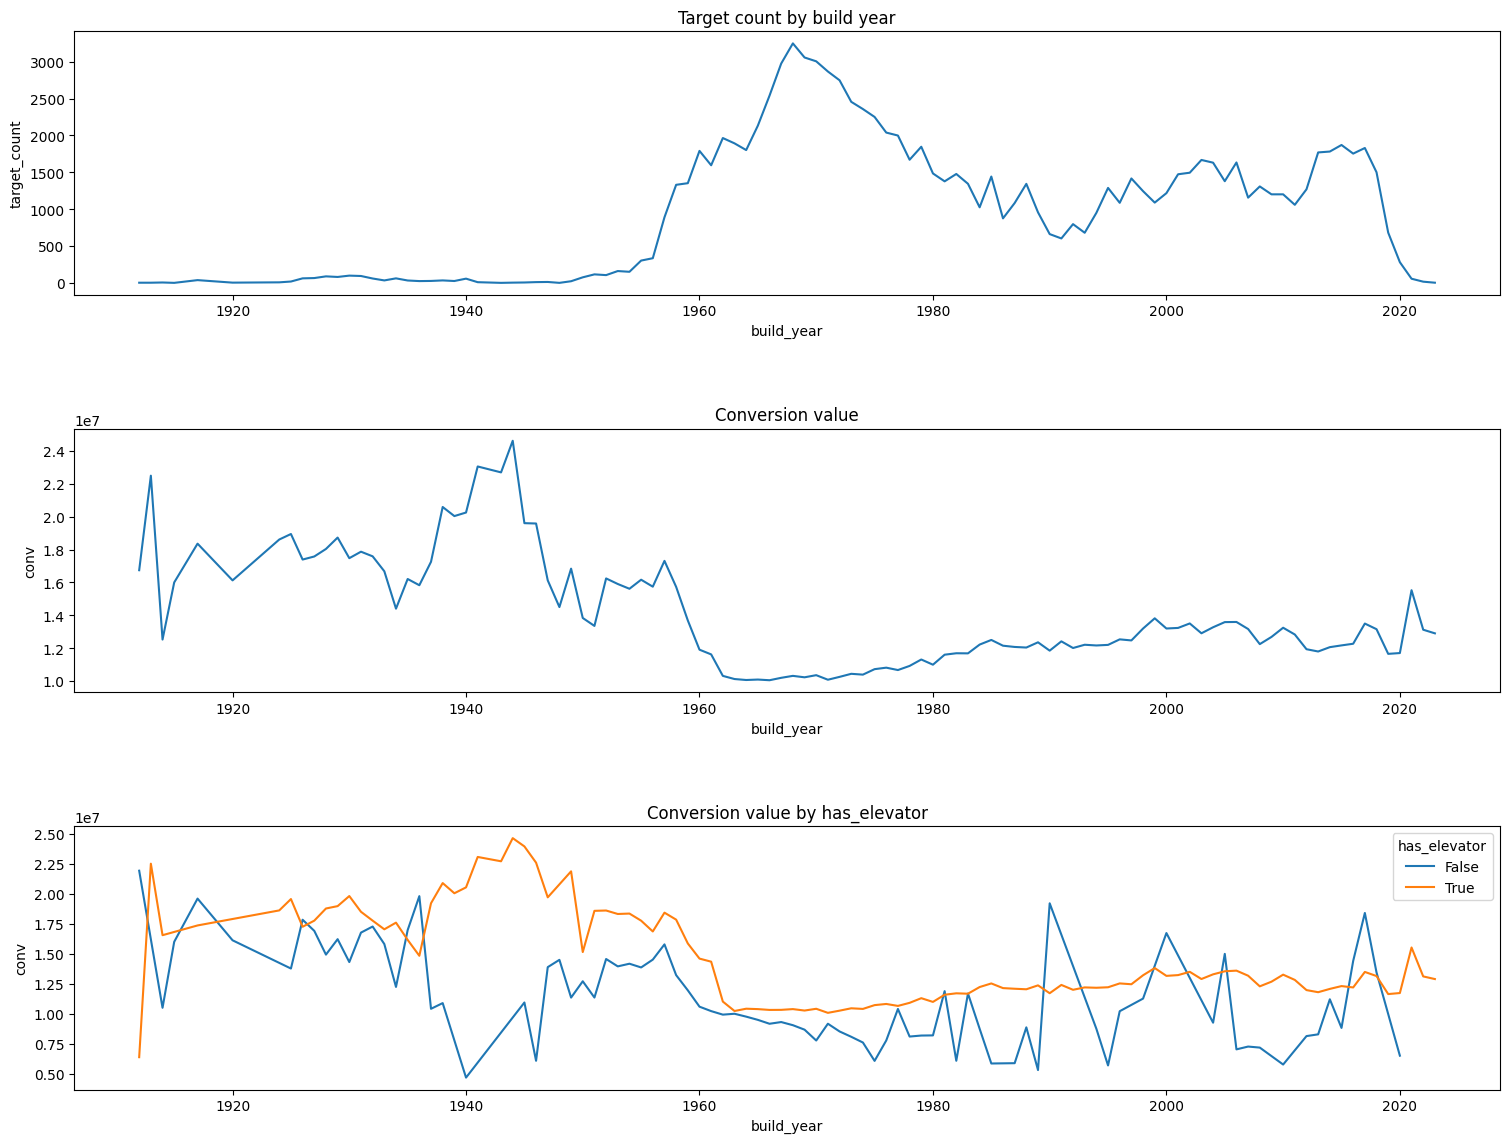

In [ ]:
# установка переменных для анализа
x = "build_year"
target = "target"

# определение статистики для агрегации
stat = ["count"]

# агрегация количества целей по датам начала с последующим сбросом индекса
target_agg_by_date = df[[x, target]].groupby([x]).agg(stat).reset_index()
# удаление мультиуровневости заголовков после агрегации и переименование для удобства
target_agg_by_date.columns = target_agg_by_date.columns.droplevel()
target_agg_by_date.columns = [x, "target_count"]

# подсчёт количества клиентов для каждого значения цели по датам
target_agg = df[[x, target, 'id']].groupby([x, target]).count().reset_index()

# расчёт суммы и количества для конверсии по датам
conversion_agg = df[[x, target]].groupby([x])['target'].agg(['sum', 'count']).reset_index()
# вычисление коэффициента конверсии и округление до двух знаков
conversion_agg['conv'] = (conversion_agg['sum'] / conversion_agg['count']).round(2)

# аналогичный расчет конверсии, но с дополнительным разделением по полу
conversion_agg_elevator = df[[x, target, 'has_elevator']].groupby([x, 'has_elevator'])[target].agg(['sum', 'count']).reset_index()
conversion_agg_elevator['conv'] = (conversion_agg_elevator['sum'] / conversion_agg_elevator['count']).round(2)

# инициализация фигуры для отображения нескольких графиков
fig, axs = plt.subplots(3, 1)
fig.tight_layout(pad=1.6)  # настройка отступов между подграфиками
fig.set_size_inches(16.5, 12.5, forward=True)  # установка размера фигуры

# визуализация общего количества целей по датам начала
sns.lineplot(data=target_agg_by_date, x=x, y='target_count', ax=axs[0])
axs[0].set_title("Target count by build year")


# визуализация коэффициента конверсии по датам
sns.lineplot(data=conversion_agg, x=x, y="conv", ax=axs[1])
axs[1].set_title("Conversion value")

# визуализация коэффициента конверсии по датам с разделением по полу
sns.lineplot(data=conversion_agg_elevator, x=x, y='conv', hue='has_elevator', ax=axs[2])
axs[2].set_title("Conversion value by has_elevator")

# сохранение визуализации в файл
plt.savefig(os.path.join(ASSETS_DIR, 'target_by_date'))

Цена на квартиру почти не зависит от наличия лифта, но старый фонд сильно дороже. Это может быть связано с тем, что старые постройки часто расположены в центре города.

Text(0.5, 1.0, 'building_type_int distribution')

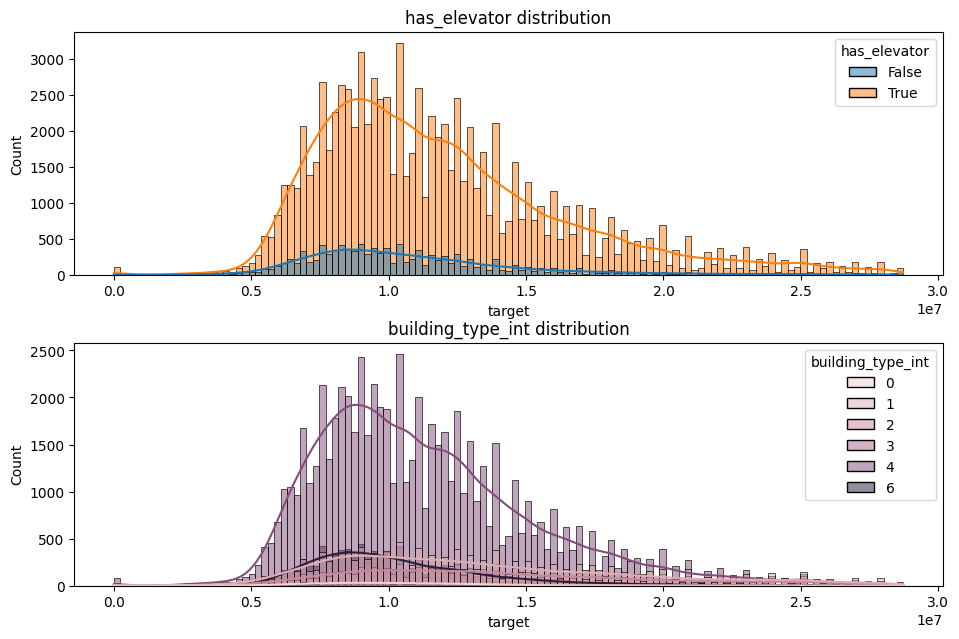

In [ ]:
# определение списка столбцов с данными о платежах и целевой переменной
charges = ["has_elevator", "building_type_int"]
target = "target"

# инициализация фигуры для отображения гистограмм
fig, axs = plt.subplots(2, 1)
fig.tight_layout(pad=1.5)  # настройка отступов между подграфиками
fig.set_size_inches(10, 6.5, forward=True)  # установка размера фигуры

# визуализация распределения целевой переменной с разделением по наличию лифта
sns.histplot(data=df, x=target, hue=charges[0], kde=True, ax=axs[0])
# указание, на каком подграфике отобразить гистограмму
axs[0].set_title(f"{charges[0]} distribution")  

# визуализация распределения целевой переменной с разделением по типу строения
sns.histplot(data=df, x=target, hue=charges[1], kde=True, ax=axs[1])
# указание, на каком подграфике отобразить вторую гистограмму
axs[1].set_title(f"{charges[1]} distribution")  

# сохранение фигуры с гистограммами в файл
plt.savefig(os.path.join(ASSETS_DIR, 'chargest_by_target_dist'))

Цена распределена нормально для разных типов зданий.

Далее изучим геоданные

In [ ]:
# За середину возьмем локацию центра Москвы
m = folium.Map(location=[55.7522, 37.6156], zoom_start=6)

# Добавим точки на карту
for lat, lon in zip(df['latitude'], df['longitude']):
    folium.CircleMarker(location=[lat, lon], radius=5, color='blue').add_to(m)

Поскольку карта занимает имеет большой размер, сохраним локацию в виде картинки только в ячейке

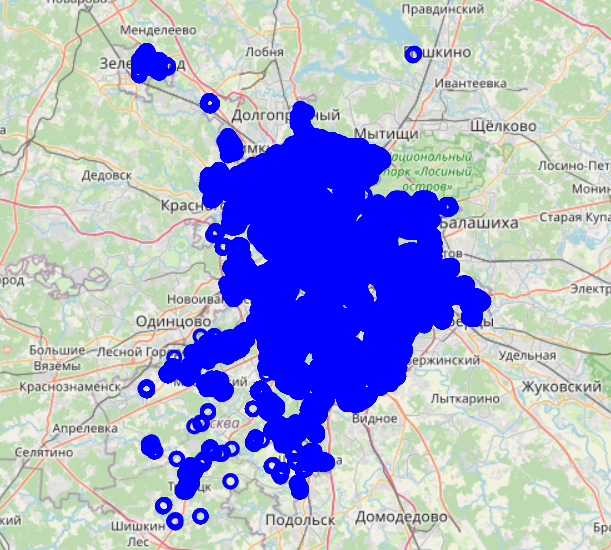

#### Выводы после EDA


1. Признаки is_apartment и studio бесполезны. В первом признаке сильный дисбаланс, а в studio одно значение.
2. Цена жилья растет с увеличением площади и этажности.
3. Цена на жилье четко делится в цене по году постройки, старый фонд (до 1960 года) имеет более высокую цену.
4. Сам целевой признак имеет нормальное распределение.
5. Наиболее широко представ слелующий тип жилья:
    - без лифта;
    - тип 4;
    - 5, 9 и 17 этажные строения;
    - квартиры находятся до 5 этажа;
    - квартиры с 2 комнатами;
    - жилая площадь до 40 кв. метров;
    - высота потолков 2,6 м, в старом фонде 3 м.

Данные относятся к инфморации и продажах в Москве и области. Чтобы дополнительно учесть локацию, можно предположить, что определенный тип построек характер для определенных районов, а также этажность и год построки. Дополнительно добавим признаки, которые можно извлеч из геоданных: разметим районы и посчитаем расстояние до центра.

##### 2.6 логирование артефактов в MLflow

In [30]:
RUN_NAME = 'feature_statistics'

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" 
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") 
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME)


with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id.experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_artifacts(ASSETS_DIR) 

2024-11-01 19:01:43,588 INFO: Found credentials in environment variables.


In [31]:
# сохраним run_id
run_id

'ff13fe71a1d84883868a027e51fc649c'

#### Этап 3: Генерация Признаков и Обучение Новой Версии Модели

Шаги этапа:

- Определение и генерация новых признаков на основе гипотез.
- Использование библиотек для автоматической генерации признаков.
- Интеграция новых признаков в  модель с помощью Pipeline или ColumnTransformer для ручно созданных признаков.
- Обучение новой версии модели с использованием всех доступных признаков.
- Логирование результатов в MLflow для документирования и анализа эффективности новых признаков и модели.


##### 3.1 ручная генерация признаков

Добавим новых признаков, основываясь на этажности и геоданных.

In [ ]:
# Добавим столбец с категорией жилого фонда по году постройки
def build_year(df):
    year_build=df['build_year']
    if year_build <=1960:
        return 'old_1900'
    elif year_build > 1960 and year_build <= 1990:
        return 'medium_1990'
    elif year_build > 1990 and year_build <= 2000:
        return 'medium_2000'
    else:
        return 'new'
    
df['build_type_by_year'] = df.apply(lambda x: build_year(x), axis=1)

df['build_type_by_year'].value_counts()

build_type_by_year
medium_1990    57500
new            28012
medium_2000    10370
old_1900        7611
Name: count, dtype: int64

In [15]:
# Добавим столбец с категорией жилого фонда по этажности
def floor_build(df):
    floor_build=df['floors_total']
    if floor_build == 5:
        return '5_level'
    elif floor_build == 9:
        return '9_level'
    elif floor_build == 17:
        return '17_level'
    else:
        return 'other_level'
    
df['build_type_by_floors'] = df.apply(lambda x: floor_build(x), axis=1)

df['build_type_by_floors'].value_counts()

build_type_by_floors
other_level    51601
9_level        21852
17_level       19354
5_level        10686
Name: count, dtype: int64

In [16]:
# Добавим признак первого и последнего этажа
def floor(df):
    floor=df['floor']
    floors_total = df['floors_total']
    if floor ==1:
        return 'first_level'
    elif floor == floors_total:
        return 'last_level'
    else:
        return 'other_level'
    
df['floor_type'] = df.apply(lambda x: floor(x), axis=1)

df['floor_type'].value_counts()

floor_type
other_level    84570
last_level      9476
first_level     9447
Name: count, dtype: int64

In [ ]:
# Разделим условно данные на 5 районов
kmeans = KMeans(n_clusters=5, random_state=0).fit(df[['latitude', 'longitude']])
df['cluster_region'] = kmeans.labels_

# Создаем базовую карту
map_center = [df['latitude'].mean(), df['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# Добавляем кластеры на карту
colors = ['red', 'blue', 'green', 'orange', 'pink']  # Цвета для кластеров

for cluster in range(5):
    cluster_data = df[df['cluster_region'] == cluster]
    folium.Marker(
        location=[cluster_data['latitude'].mean(), cluster_data['longitude'].mean()],
        popup=f'Cluster {cluster}',
        icon=folium.Icon(color=colors[cluster], icon='info-sign')
    ).add_to(m)

# Добавляем маркеры для всех точек с их цветом в зависимости от кластера
for idx, row in df.iterrows():
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=5,
        color=colors[row['cluster_region']],
        fill=True,
        fill_color=colors[row['cluster_region']],
        fill_opacity=0.7,
        popup=f'Cluster: {row["cluster_region"]}'
    ).add_to(m)


Посмотрим далее на полученное разделение.

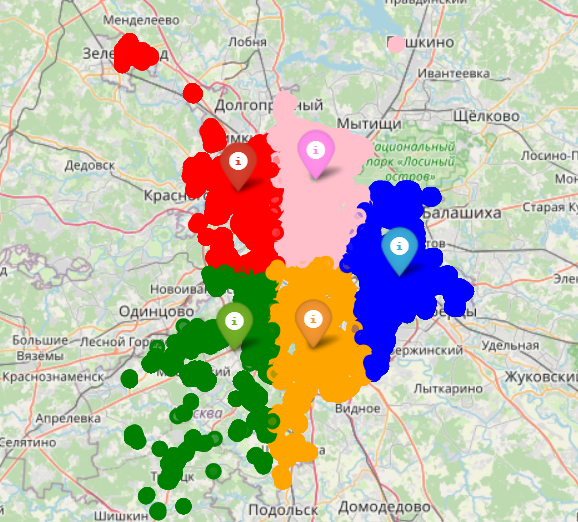

Центр города не был выделен в отдельный район. Косвенно компенсировать это можно если учесть расстояние до центра.

In [ ]:
# Зададим координаты центра города
moscow = (55.753114, 37.623681)

# Функция для вычисления расстояния от дома до центра
def distance_to_center(row):
    location = (row['latitude'], row['longitude'])
    distance_km = great_circle(moscow, location).kilometers
    return distance_km


# Применяем функцию к DataFrame и создаем новый столбец с расстоянием
df['distance_to_center'] = df.apply(distance_to_center, axis=1)

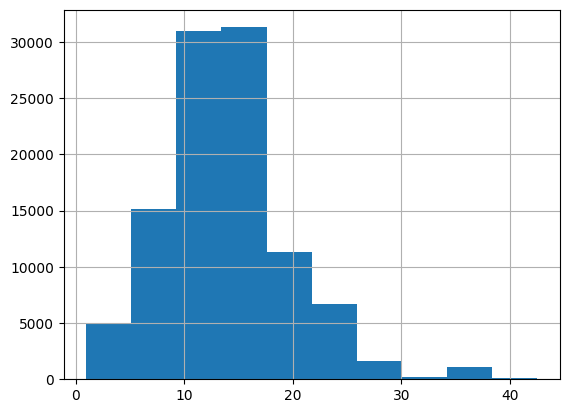

In [28]:
# Посмотрим на распределение нового признака
df['distance_to_center'].hist();

##### 3.2 Оборачивание всех преобразований в объекты sklearn

In [108]:
# Разделим датасет и удалим неинформативные признаки
X = df.drop(['target', 'id','building_id', 'studio', 'is_apartment'], axis=1)
y = df['target']

# Заменим тип категориального столбца
X['building_type_int'] = X['building_type_int'].astype('object')

In [109]:
# Напишем методы для функций генерации признаков

class BuildYearTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        def build_year(year_build):
            if year_build <= 1960:
                return 'old_1900'
            elif 1960 < year_build <= 1990:
                return 'medium_1990'
            elif 1990 < year_build <= 2000:
                return 'medium_2000'
            else:
                return 'new'

        return X.assign(build_type_by_year=X['build_year'].apply(build_year))


class FloorBuilderTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        def floor_build(floor_build):
            if floor_build == 5:
                return '5_level'
            elif floor_build == 9:
                return '9_level'
            elif floor_build == 17:
                return '17_level'
            else:
                return 'other_level'

        return X.assign(build_type_by_floors=X['floors_total'].apply(floor_build))


class FloorTypeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        def floor(row):
            floor_value = row['floor']
            floors_total = row['floors_total']
            if floor_value == 1:
                return 'first_level'
            elif floor_value == floors_total:
                return 'last_level'
            else:
                return 'other_level'

        return X.assign(floor_type=X.apply(floor, axis=1))


class KMeansClusterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=5):
        self.n_clusters = n_clusters
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=0)

    def fit(self, X, y=None):
        self.kmeans.fit(X[['latitude', 'longitude']])
        return self

    def transform(self, X):
        X['cluster_region'] = self.kmeans.labels_
        X['cluster_region'] = X['cluster_region'].astype('object')
        return X


class DistanceToCenterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, center_location):
        self.center_location = center_location

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        def distance_to_center(row):
            location = (row['latitude'], row['longitude'])
            distance_km = great_circle(self.center_location, location).kilometers
            return distance_km
        
        X['distance_to_center'] = X.apply(distance_to_center, axis=1)
        return X
    

CENTER_COORD = (55.7558, 37.6173)  # Координаты Москвы

feature_generation = Pipeline(steps=[
    ('build_year', BuildYearTransformer()),
    ('floor_builder', FloorBuilderTransformer()),
    ('floor_type', FloorTypeTransformer()),
    ('kmeans_cluster', KMeansClusterTransformer(n_clusters=5)),
    ('distance_to_center', DistanceToCenterTransformer(center_location=CENTER_COORD)),
    
])

In [110]:
# Добавим новые признаки
X_generated = feature_generation.fit_transform(X)

##### 3.3 Автоматическая генерация признаков

Поскольку генерация производится с использованием целевой переменной - необходимо разделить датасет, в который ранее были добавлены дополнительные признаки.

In [138]:
# Разделим датасет с новыми признаками
X_train, X_test, y_train, y_test = train_test_split(
        X_generated, y, shuffle=True, test_size=0.25, random_state=RANDOM_STATE)

print(f'Размер тренировочного набора: {X_train.shape}, {y_train.shape}')
print(f'Размер тестового набора: {X_test.shape}, {y_test.shape}')

Размер тренировочного набора: (77619, 18), (77619,)
Размер тестового набора: (25874, 18), (25874,)


In [139]:
# Зададим параметры
degree = 3
n_bins = 5
encode = 'ordinal'
strategy = 'uniform'
subsample = None

# определение категориальных колонок, которые будут преобразованы
cat_columns = X_train.select_dtypes(['object', 'bool']).columns.to_list()

# Не будем брать все числовые признаки, иначе автоматический отбор и обучение будут идти слишком долго
num_columns = X_train.select_dtypes(['int', 'float']).columns.to_list()

# OneHotEncoder
encoder_oh = OneHotEncoder(categories='auto', 
                           handle_unknown='ignore', 
                           max_categories=10, 
                           sparse_output=False, 
                           drop='first')

# StandardScaler
encoder_rb = StandardScaler()
# PolynomialFeatures
encoder_pol = PolynomialFeatures(degree=degree)
# KBinsDiscretizer
encoder_kbd = KBinsDiscretizer(n_bins=n_bins, encode=encode, strategy=strategy, subsample=subsample)

In [140]:

# Применим описанные выше методы

# Определим трансформер для числовых переменных
numeric_transformer = ColumnTransformer(transformers=[ 
                                                      ('rb', encoder_rb, num_columns), 
                                                      ('pol', encoder_pol,  ['ceiling_height', 'total_area']), 
                                                      ('kbd', encoder_kbd,  ['ceiling_height', 'total_area'])])

# Определим категоризацию
categorical_transformer = Pipeline(steps=[('encoder', encoder_oh)])

# Определим общий трансформер
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, num_columns),
                                               ('cat', categorical_transformer, cat_columns)], 
                                 n_jobs=-1)

# Применим трансформацию для тренировочного и тестового датасетов
encoded_features_train = preprocessor.fit_transform(X_train)
encoded_features_test = preprocessor.transform(X_test)

# Создадим датасеты с трансформированными признаками
X_train_tmd = pd.DataFrame(encoded_features_train, columns=preprocessor.get_feature_names_out())
X_test_tmd = pd.DataFrame(encoded_features_test, columns=preprocessor.get_feature_names_out())

# Сбросим индексы у таргетов
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


In [141]:
# Определим операции для автоматической генерации признаков
transformations = ('exp', 'sqrt')

# Определим метод трансформации
afc = AutoFeatRegressor(transformations=transformations, 
                        feateng_cols=["rooms", "living_area"],
                         feateng_steps=3, 
                         n_jobs=-1)

# Сгенерируем новые признаки
X_train_genf = afc.fit_transform(X_train[["rooms", "living_area"]].reset_index(drop=True), y_train)
X_test_genf = afc.transform(X_test[["rooms", "living_area"]].reset_index(drop=True))

In [142]:
# Объединим новые признаки с ранее полученными
X_train_features = pd.concat([X_train_tmd, X_train_genf.drop(["rooms", "living_area"], axis=1)], axis=1)
X_test_features = pd.concat([X_test_tmd, X_test_genf.drop(["rooms", "living_area"], axis=1)], axis=1)

In [145]:
# Посмотрим на результат
X_train_features.head(3)

,num__rb__build_year,num__rb__latitude,num__rb__longitude,num__rb__ceiling_height,num__rb__flats_count,num__rb__floors_total,num__rb__floor,num__rb__kitchen_area,num__rb__living_area,num__rb__rooms,num__rb__total_area,num__rb__distance_to_center,num__pol__1,num__pol__ceiling_height,num__pol__total_area,num__pol__ceiling_height^2,num__pol__ceiling_height total_area,num__pol__total_area^2,num__pol__ceiling_height^3,num__pol__ceiling_height^2 total_area,num__pol__ceiling_height total_area^2,num__pol__total_area^3,num__kbd__ceiling_height,num__kbd__total_area,cat__building_type_int_1,cat__building_type_int_2,cat__building_type_int_3,cat__building_type_int_4,cat__building_type_int_6,cat__has_elevator_True,cat__build_type_by_year_medium_2000,cat__build_type_by_year_new,cat__build_type_by_year_old_1900,cat__build_type_by_floors_5_level,cat__build_type_by_floors_9_level,cat__build_type_by_floors_other_level,cat__floor_type_last_level,cat__floor_type_other_level,cat__cluster_region_1,cat__cluster_region_2,cat__cluster_region_3,cat__cluster_region_4,exp(rooms),exp(-living_area + rooms),exp(sqrt(rooms) - exp(rooms)),exp(sqrt(living_area) - rooms),exp(-living_area + sqrt(rooms)),exp(sqrt(living_area) - exp(rooms)),exp(sqrt(living_area) - sqrt(rooms))
0,-0.729150,0.311378,-0.396650,-0.360827,-1.067506,-0.198709,0.507520,0.467404,-0.536925,-1.157093,-1.042188,-1.646862,1.0,2.64,34.700001,6.969601,91.608006,1204.090053,18.399746,241.845145,3178.797866,41781.925756,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2.718282,6.843276e-09,0.179374,31.491542,6.843276e-09,5.648766,31.491542
1,-0.677481,0.474426,0.808117,-0.360827,-0.933406,0.191776,1.173218,-0.707402,-0.245603,0.069350,-0.406179,-1.188469,1.0,2.64,45.000000,6.969601,118.800005,2025.000000,18.399746,313.632025,5346.000212,91125.000000,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,7.389056,2.789468e-10,0.002542,18.155608,1.552807e-10,0.082904,32.614792
2,1.595920,-1.213924,-1.643144,0.098049,1.279255,0.777503,-0.823878,-0.036084,-0.599351,-1.157093,-0.850768,1.640928,1.0,2.70,37.799999,7.290000,102.060000,1428.839942,19.683001,275.562004,3857.867912,54010.148730,2.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.718282,1.683174e-08,0.179374,28.429092,1.683174e-08,5.099442,28.429092


In [146]:
# Посмотрим на результат
X_test_features.head(3)

,num__rb__build_year,num__rb__latitude,num__rb__longitude,num__rb__ceiling_height,num__rb__flats_count,num__rb__floors_total,num__rb__floor,num__rb__kitchen_area,num__rb__living_area,num__rb__rooms,num__rb__total_area,num__rb__distance_to_center,num__pol__1,num__pol__ceiling_height,num__pol__total_area,num__pol__ceiling_height^2,num__pol__ceiling_height total_area,num__pol__total_area^2,num__pol__ceiling_height^3,num__pol__ceiling_height^2 total_area,num__pol__ceiling_height total_area^2,num__pol__total_area^3,num__kbd__ceiling_height,num__kbd__total_area,cat__building_type_int_1,cat__building_type_int_2,cat__building_type_int_3,cat__building_type_int_4,cat__building_type_int_6,cat__has_elevator_True,cat__build_type_by_year_medium_2000,cat__build_type_by_year_new,cat__build_type_by_year_old_1900,cat__build_type_by_floors_5_level,cat__build_type_by_floors_9_level,cat__build_type_by_floors_other_level,cat__floor_type_last_level,cat__floor_type_other_level,cat__cluster_region_1,cat__cluster_region_2,cat__cluster_region_3,cat__cluster_region_4,exp(rooms),exp(-living_area + rooms),exp(sqrt(rooms) - exp(rooms)),exp(sqrt(living_area) - rooms),exp(-living_area + sqrt(rooms)),exp(sqrt(living_area) - exp(rooms)),exp(sqrt(living_area) - sqrt(rooms))
0,-0.729150,0.604791,-0.844728,-0.360827,-0.337403,-0.784436,0.285620,-0.707402,-0.523052,-1.157093,-1.085412,-0.782178,1.0,2.64,34.000000,6.969601,89.760004,1156.000000,18.399746,236.966419,3051.840121,39304.000000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.718282,5.602796e-09,1.793741e-01,32.205458,5.602796e-09,5.776824,32.205458
1,-0.574145,-0.166945,1.678422,-0.360827,0.243700,-0.784436,0.063720,-0.673836,0.205252,0.069350,-0.288856,0.290501,1.0,2.64,46.900002,6.969601,123.816009,2199.610143,18.399746,326.874277,5806.971009,103161.719069,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,7.389056,4.193796e-13,2.541902e-03,33.875109,2.334551e-13,0.154683,60.853355
2,1.337579,-0.229838,2.091056,0.403966,2.203059,0.777503,1.617018,0.635234,1.835265,1.295793,1.767368,0.965489,1.0,2.74,80.199997,7.507600,219.747992,6432.039510,20.570824,602.109501,17623.788320,515849.549113,2.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,20.085537,7.095474e-23,1.069504e-08,77.359952,1.996724e-23,0.000003,274.903031


##### 3.4 Обучение новой версии модели

Далее обучим новую модель с сгенерированными признаками

In [147]:
# Определим модель
model_fg = CatBoostRegressor(n_estimators=1000,
                              random_seed=42,
                              verbose=False,
                              eval_metric='RMSE')

# Обучим модель
model_fg.fit(X_train_features, y_train.values)

In [148]:
# Получим предсказание
y_pred = model_fg.predict(X_test_features)

In [149]:
# Сохраним результат на тесте
res_test = root_mean_squared_error(y_test, y_pred)

print(f'Результат на тестовой выборке, RMSE: {round(res_test, 3)}')

Результат на тестовой выборке, RMSE: 2360736.312


In [151]:
# Получим результат при обучении с кросс-валидацией
cv_strategy = StratifiedKFold(n_splits=3)
cv_res = cross_validate(
        model_fg,
        X_train_features,
        y_train.values,
        cv=cv_strategy,
        n_jobs=-1,
        scoring='neg_root_mean_squared_error'
        )
for key, value in cv_res.items():
        cv_res[key] = round(value.mean(), 3)

print(f'Результат при кросс-валидации, RMSE: {abs(cv_res[key])}')


Результат при кросс-валидации, RMSE: 2381652.499


In [152]:
RESULTS_FILE_TEST = 'test_res_v2.json'
RESULTS_FILE = 'cv_res_v2.json'

# Сохраним результат теста
with open(f'{RESULTS_DIR}/{RESULTS_FILE_TEST}', 'w') as f:
    json.dump(res_test, f)

# Сохраним результат кросс-валидации
with open(f'{RESULTS_DIR}/{RESULTS_FILE}', 'w') as f:
    json.dump(cv_res, f)

Результат получился несмного лучше, чем для базовой модели.

##### 3.5 логирование артефактов в MLflow

In [153]:
res_test_log = {'RMSE_test': res_test}

In [ ]:
RUN_NAME = 'feature_generation_model'
artifact_path_afc = "afc"
artifact_path_m = "manual"
artifact_path_auto = "auto"

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" 
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") 
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")


mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

# настройки для логирования в MLFlow
pip_requirements = '../requirements.txt'
signature = mlflow.models.infer_signature(X_test_features, y_pred)
input_example = X_test_features[:10]

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    
    mlflow.log_metrics(cv_res)
    mlflow.log_metrics(res_test_log)
    
    mlflow.log_artifacts(ASSETS_DIR) 

    model_info = mlflow.catboost.log_model( 
        cb_model=model_fg,
        artifact_path="models",
        registered_model_name=REGISTRY_MODEL_NAME,
        signature=signature,
        input_example=input_example,
        await_registration_for=60,
        pip_requirements=pip_requirements)

Registered model 'real_estate_model_base' already exists. Creating a new version of this model...
2024/11/02 19:05:31 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: real_estate_model_base, version 9
Created version '9' of model 'real_estate_model_base'.


In [155]:
# Сохраним run_id
run_id

'10961ab3807243e89d437318bffaf553'

#### Этап 4: Отбор Признаков и Обучение Новой Версии Модели

Шаги этапа:

- Применение методов отбора признаков для идентификации и исключения признаков, ухудшающих качество модели.
- Анализ влияния каждого признака на модель, чтобы понять, какие из них наиболее ценные.
- Обучение новой версии модели без негативно влияющих признаков.
- Логирование всех изменений и результатов в MLflow, включая конечный набор признаков, параметры модели и метрики качества.


##### 4.1 Отбор признаков при помощи метода номер 1

Признаков получается много и отбор может занимать несколько часов. Чтобы сократить время, пожертвуем качеством и сократим выборку.

Для начала отберем 15 лучших признаков, начиная с пустого набора.

In [156]:
# Отберем 1000 слачайных строк
X_train_sample = X_train_features.sample(1000)
ind = X_train_sample.index

y_train_sample = y_train.reset_index(drop=True)
y_train_sample = y_train_sample[ind]

# В качестве модели определим случайный лес
estimator = RandomForestRegressor(n_estimators=100)

# Зададим параметры выборщика
sfs = SFS(estimator,
    k_features=15,       
    forward=True,      
    floating=False,     
    scoring='neg_root_mean_squared_error', 
    cv=2,               
    n_jobs=-1
)


sfs = sfs.fit(X_train_sample, y_train_sample)

/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv_project_name/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv_project_name/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv_project_name/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv_project_name/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_p

##### 4.2 Отбор признаков при помощи метода номер 2

Далее отберем 15 признаков, начиная с полного набора признаков.

In [157]:
# Зададим параметры выборщика
sbs = SFS(estimator,
    k_features=15,       
    forward=False,      
    floating=False,     
    scoring='neg_root_mean_squared_error', 
    cv=2,               
    n_jobs=-1
)

sbs = sbs.fit(X_train_sample, y_train_sample)

/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv_project_name/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv_project_name/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv_project_name/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv_project_name/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_p

##### 4.3 Анализ отобранных признаков при помощи двух методов и формирование финального списка с признаками для модели

In [159]:
# Сохраним признаки полученные двумя способами
top_sfs = sfs.k_feature_names_
top_sbs = sbs.k_feature_names_

# Выведем метрики для первого и второго набора
print('\nSequential Forward Selection (k=10)')
print('CV Score:')
print(sfs.k_score_)
print(sbs.k_score_)


Sequential Forward Selection (k=10)
CV Score:
-2753944.551986756
-2787715.497594976


Результаты подучились хуже, чем с полным набором признаков.

In [160]:
# Сохраним датасеты с ходом отбора признаков
sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sbs_df = pd.DataFrame.from_dict(sbs.get_metric_dict()).T 


sfs_df.to_csv(f"{FS_ASSETS}/sfs.csv")
sbs_df.to_csv(f"{FS_ASSETS}/sbs.csv")

Далее выведем и сохраним визуализацию хода отбра признаков двумя способами.

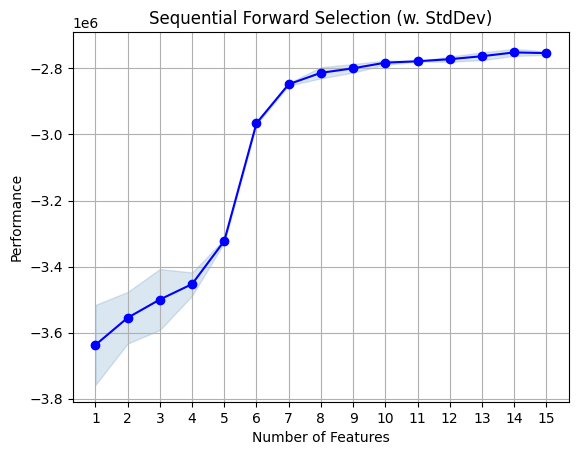

<Figure size 640x480 with 0 Axes>

In [161]:
fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig(f"{FS_ASSETS}/sfs.png") 

По графику выше можно заметить, что с увеличением количества признаков растет, выходя на небольшое плато перед окончанием.

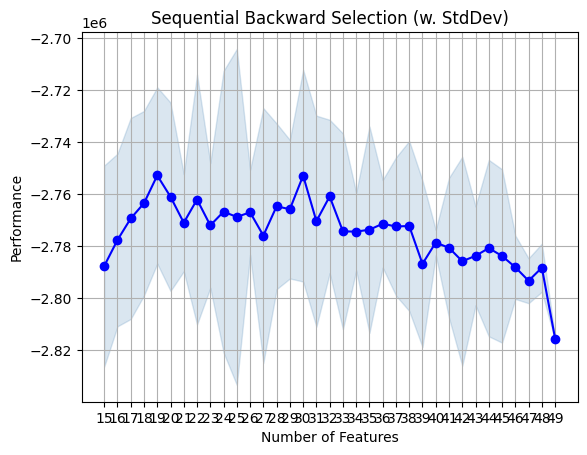

<Figure size 640x480 with 0 Axes>

In [162]:
fig = plot_sfs(sbs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig(f"{FS_ASSETS}/sbs.png")

In [163]:
# Объединим полученные признаки, чтобы получить больше данных
union_features = list(set(top_sbs) | set(top_sfs))

In [164]:
# Выведем полученный список
union_features

['cat__building_type_int_2',
 'cat__cluster_region_2',
 'cat__build_type_by_year_medium_2000',
 'num__rb__rooms',
 'num__rb__floor',
 'num__rb__ceiling_height',
 'cat__build_type_by_floors_other_level',
 'cat__floor_type_other_level',
 'exp(-living_area + sqrt(rooms))',
 'num__rb__latitude',
 'num__rb__longitude',
 'num__pol__ceiling_height total_area',
 'exp(sqrt(living_area) - exp(rooms))',
 'cat__building_type_int_4',
 'cat__building_type_int_3',
 'num__rb__distance_to_center',
 'cat__cluster_region_4',
 'num__rb__build_year',
 'num__pol__total_area^2',
 'num__kbd__total_area',
 'exp(rooms)',
 'num__rb__floors_total',
 'num__pol__ceiling_height^2',
 'cat__cluster_region_1']

В новый набор также попали признаки, которые были сгенерированы вручную на основе EDA.

##### 4.4 Обучение новой версии модели

Далее обучим модель на новом наборе признаков и сравним результаты. Обучение точно пройдет быстрее, а это значит, что иногда можно пожертвовать качеством в пользу быстроты обучения.

In [165]:
# Определим модель
model_un = CatBoostRegressor(n_estimators=1000,
                              random_seed=42,
                              verbose=False,
                              eval_metric='RMSE')

# Обучим модель
model_un.fit(X_train_features[union_features], y_train.values)

In [166]:
# Получим предсказание
y_pred_un = model_un.predict(X_test_features[union_features])

# Посчитаем метрику
res_test_un = root_mean_squared_error(y_test, y_pred_un)

print(f'Результат на тестовой выборке, RMSE: {round(res_test_un, 3)}')

Результат на тестовой выборке, RMSE: 2370428.363


In [167]:
# Сохраним результат теста
res_test_log = {'RMSE_test': res_test}

In [168]:
# Получим результат при обучении с кросс-валидацией

cv_strategy = StratifiedKFold(n_splits=3)
cv_res = cross_validate(
        model_un,
        X_train_features[union_features],
        y_train.values,
        cv=cv_strategy,
        n_jobs=-1,
        scoring='neg_root_mean_squared_error'
        )
for key, value in cv_res.items():
        cv_res[key] = round(value.mean(), 3)

print(f'Результат при кросс-валидации, RMSE: {abs(cv_res[key])}')

Результат при кросс-валидации, RMSE: 2391802.497


Метрика получилась немного хуже. Обучение значительно ускорилось, поэтому оставим такой набор для дальнейшей работы.

In [169]:
# Сохраним результаты

RESULTS_FILE_TEST = 'test_res_v3.json'
RESULTS_FILE = 'cv_res_v3.json'

# Сохраним результат теста
with open(f'{RESULTS_DIR}/{RESULTS_FILE_TEST}', 'w') as f:
    json.dump(res_test_un, f)

# Сохраним результат кросс-валидации
with open(f'{RESULTS_DIR}/{RESULTS_FILE}', 'w') as f:
    json.dump(cv_res, f)

##### Логирование всех артефактов в MLflow

In [170]:
# Определим новый ран и залогируем результаты
RUN_NAME = 'feature_selected_model'
artifact_path_afc = "afc"
artifact_path_m = "manual"
artifact_path_auto = "auto"

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" 
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") 
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")


mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

# настройки для логирования в MLFlow
pip_requirements = '../requirements.txt'
signature = mlflow.models.infer_signature(X_test_features[union_features], y_pred_un)
input_example = X_test_features[union_features][:10]

# В первый раз создадим эксперимент
#experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    
    mlflow.log_metrics(cv_res)
    mlflow.log_metrics(res_test_log)
    
    # Залогируем пайплайны для генерации признаков
    mlflow.log_artifacts(FS_ASSETS) 

    model_info = mlflow.catboost.log_model( 
        cb_model=model_un,
        artifact_path="models",
        registered_model_name=REGISTRY_MODEL_NAME,
        signature=signature,
        input_example=input_example,
        await_registration_for=60,
        pip_requirements=pip_requirements)

Registered model 'real_estate_model_base' already exists. Creating a new version of this model...
2024/11/02 19:33:31 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: real_estate_model_base, version 10
Created version '10' of model 'real_estate_model_base'.


In [171]:
# Сохраним run_id
run_id

'0d21eefd695d4cc09332f632a061a690'

### Этап 5 - подбор гиперпараметров и обучение новой версии модели

Шаги этапа:

- Выбор методов для подбора гиперпараметров: Random Search и optuna.
- Подбор гиперпараметров.
- Сравнение результатов.
- Обучение финальной модели.
- Документирование процесса и результатов

##### 5.1 Подбор гиперпарметров при помощи метода номер 1

Для подбора гиперпараметров будем использовать два метода - рандомный поиск по сетке и optuna. Первый способ самый быстрые, второй самый подробный с множеством функций для работы.

In [182]:
# Определим параметры модели

eval_metric = "RMSE"
task_type = 'CPU'
random_seed = 0
iterations = 300
verbose = False


# Определим сетку параметров
param_distributions = {
    'depth': [3, 4, 5, 6, 7],
    'learning_rate': np.logspace(-3, -1, 5),
    'iterations': [10, 20, 30],
    'l2_leaf_reg': np.logspace(-2, 0, 3)
} 

# Определим модель
model = CatBoostRegressor(eval_metric=eval_metric,
                  task_type = task_type,
                  random_seed = random_seed,
                  iterations = iterations,
                  verbose=verbose)

# Определим параметры поиска
cv = RandomizedSearchCV(estimator=model, 
                        param_distributions=param_distributions, 
                        cv=3,
                        n_jobs=-1,
                        n_iter=20)

# Обучим модель
clf = cv.fit(X_train_features[union_features], y_train)

# Сохраним результаты и лучшие параметры
cv_results = pd.DataFrame(clf.cv_results_)
best_params = clf.best_params_

In [183]:
# Определим модель с лучшими параметрами
model_best = CatBoostRegressor(**best_params,
                               eval_metric=eval_metric,
                               task_type = task_type,
                               random_seed = random_seed,
                               verbose=verbose)

# Обучим модель с лучшими параметрами
model_best.fit(X_train_features[union_features], y_train)

In [184]:
# Получим предсказание
prediction = model_best.predict(X_test_features[union_features])

# Посчитаем метрику
res_test_rs = root_mean_squared_error(y_test, prediction)

print(f'Результат на тестовой выборке, RMSE: {round(res_test_rs, 3)}')

Результат на тестовой выборке, RMSE: 2680502.634


Вариант с подбором гиперпараметров получился хуже, чем базовая модель.

In [185]:
# Сохраним результаты
res_test_log = {'RMSE_test': res_test_rs}

RESULTS_FILE_TEST = 'test_res_v4.json'

# Сохраним результат теста
with open(f'{RESULTS_DIR}/{RESULTS_FILE_TEST}', 'w') as f:
    json.dump(res_test_rs, f)

In [186]:
# Орпделим новый ран и залогируем артефакты
RUN_NAME = 'random_gs_best_model'


os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" 
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") 
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")


mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

# настройки для логирования в MLFlow
pip_requirements = '../requirements.txt'
signature = mlflow.models.infer_signature(X_test_features[union_features], prediction)
input_example = X_test_features[union_features][:10]


experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    
    mlflow.log_metrics(res_test_log)
    mlflow.log_params(best_params)
    cv_info = mlflow.sklearn.log_model(cv, artifact_path='cv')

    model_info = mlflow.catboost.log_model( 
		cb_model=model_best,
        artifact_path="models",
        registered_model_name=REGISTRY_MODEL_NAME,
        signature=signature,
        input_example=input_example,
        await_registration_for=60,
        pip_requirements=pip_requirements)

Registered model 'real_estate_model_base' already exists. Creating a new version of this model...
2024/11/02 19:38:24 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: real_estate_model_base, version 11
Created version '11' of model 'real_estate_model_base'.


In [187]:
# Сохраним run_id
run_id

'82adc8312f92442b952cbf471767cfd9'

##### 5.2 Подбор гиперпарметров при мощи метода номер 2

Далее применим optuna для подбора гиперпараметров.

In [188]:
# Определим новый ран чтобы логировать эксперименты
RUN_NAME = 'optuna_model'
STUDY_DB_NAME = "sqlite:///local.study.db"
STUDY_NAME = "real_estate_optuna_model_v2"

# Определим функцию проведения экспериментов
def objective(trial: optuna.Trial) -> float:
    
    param = {
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "random_seed": 42,
        "eval_metric": "RMSE",
        "iterations": 300,
        "verbose": False 
        }

        
    
    model = CatBoostRegressor(**param)

    skf = StratifiedKFold(n_splits=2)

    metrics = defaultdict(list)
    for i, (train_index, val_index) in enumerate(skf.split(X_train_features[union_features], y_train)):
        train_x = X_train_features.iloc[train_index]
        val_x = X_train_features.iloc[val_index]
        train_y = y_train.iloc[train_index]
        val_y = y_train.iloc[val_index]
        
        model.fit(train_x, train_y)
        prediction = model.predict(val_x)

        rmse = root_mean_squared_error(val_y, prediction)
    
        metrics["rmse"].append(rmse)


    rmse =  np.median(metrics['rmse'])
		

    return rmse


experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if not experiment:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id
    

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

mlflc = MLflowCallback(
    tracking_uri=f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}",
    metric_name="RMSE",
    create_experiment=False,
    mlflow_kwargs={'experiment_id': experiment_id, 'tags': {'mlflow.parentRunId': run_id}}) 

study = optuna.create_study(direction='minimize', 
                            study_name=STUDY_NAME, 
                            storage=STUDY_DB_NAME, 
                            sampler=optuna.samplers.TPESampler(),
                            load_if_exists=True)

study.optimize(objective, n_trials=10, callbacks=[mlflc])

best_params = study.best_params

# Выведем результаты
print(f"Number of finished trials: {len(study.trials)}")
print(f"Best params: {best_params}")
print('Best RMSE:', study.best_value)

[I 2024-11-02 19:38:52,180] A new study created in RDB with name: real_estate_optuna_model_v2
[I 2024-11-02 19:38:57,491] Trial 0 finished with value: 3724073.8737467835 and parameters: {'depth': 4, 'learning_rate': 0.0014868459738580117, 'bootstrap_type': 'MVS', 'colsample_bylevel': 0.9571002346171857}. Best is trial 0 with value: 3724073.8737467835.
[I 2024-11-02 19:39:02,473] Trial 1 finished with value: 2628914.660290878 and parameters: {'depth': 6, 'learning_rate': 0.010189662316802621, 'bootstrap_type': 'Bernoulli', 'colsample_bylevel': 0.318580995370419}. Best is trial 1 with value: 2628914.660290878.
[I 2024-11-02 19:39:06,057] Trial 2 finished with value: 3064922.1252015075 and parameters: {'depth': 4, 'learning_rate': 0.004627518462062883, 'bootstrap_type': 'Bernoulli', 'colsample_bylevel': 0.33456621410682197}. Best is trial 1 with value: 2628914.660290878.
[I 2024-11-02 19:39:09,030] Trial 3 finished with value: 3036432.8380054617 and parameters: {'depth': 4, 'learning_rate

Number of finished trials: 10
Best params: {'depth': 8, 'learning_rate': 0.06666701898166658, 'bootstrap_type': 'Bayesian', 'colsample_bylevel': 0.7399553184795292}
Best RMSE: 2424998.791742418


In [190]:
# Сохраним run_id
run_id

'02976cf091104346b58c0f7340976914'

##### 5.3 Формирование списка гиперпараметров для новой модели

Лучшая метрика была получена при помощи отбора признаков и оптимизации гиперпараметров optuna. Далее визуализируем некоторые результаты подбора параметров.

In [191]:
# История изменения целевой функции
his_plot = optuna.visualization.plot_optimization_history(study)
his_plot.show()

plt.savefig(f"{OP_ASSETS}/his_plot.png")

<Figure size 640x480 with 0 Axes>

Алгоритм почти сразу нашел неплохие параметры.

In [ ]:
# Кумулятивность целевой функции
emp_dist = optuna.visualization.plot_edf([study])
emp_dist.show() 

plt.savefig(f"{OP_ASSETS}/emp_dist.png")

<Figure size 640x480 with 0 Axes>

Можно заметить, что испытания показывают лучшую целевую метрику с увеличением кумулятивной вероятности.

In [193]:
# Важность гиперпараметров
hyp_imp = optuna.visualization.plot_param_importances(study)
hyp_imp.show() 

plt.savefig(f"{OP_ASSETS}/hyp_imp.png")

<Figure size 640x480 with 0 Axes>

Наиболее значимыми оказались параметры learning_rate и colsample_bylevel.

In [194]:
# График параллельных координат для более важных признаков
par_coord = optuna.visualization.plot_parallel_coordinate(study, params=["learning_rate", "colsample_bylevel"])
par_coord.show() 

plt.savefig(f"{OP_ASSETS}/par_coord.png")

<Figure size 640x480 with 0 Axes>

Линии, показывающие рост целевой функции сосредоточены в определенной области графика.

In [196]:
# График среза
slice_plot = optuna.visualization.plot_slice(study, params=["learning_rate", "colsample_bylevel"])
slice_plot.show() 

plt.savefig(f"{OP_ASSETS}/slice_plot.png")

<Figure size 640x480 with 0 Axes>

Для learning_rate оптимальная зона сосредоточена после значения 0,01

При помощи оптимизации параметров удалось не удалось достичь минимальной ошибки на валидации. Модель с базовыми параметрами и полным набором признаков получила лучший результат. Возможно, исходная сетка параметров подобрана неоптимально.

##### 5.4 Обучение финальной версии модели

Из двух способо отбора гиперпараметров лучшим оказалась optuna. Сохраним полученнве параметры и обучим новую модель.

In [ ]:
# Скопируем параметры и сохраним в переменной
best_params =  {'depth': 5, 
                'learning_rate': 0.08013219739955416, 
                'bootstrap_type': 'Bernoulli', 
                'colsample_bylevel': 0.9610712344523746,
                "random_seed": 42,
                "eval_metric": "RMSE",
                "iterations": 300}

# Определим модель
model_best = CatBoostRegressor(**best_params,
                                verbose=False)

# Обучим модель
model_best.fit(X_train_features[union_features], y_train)

In [199]:
# Сделаем прогноз и сохраним результат на тесте
y_pred = model_best.predict(X_test_features[union_features])

res_test = root_mean_squared_error(y_test, y_pred)
print(f'Результат на тестовой выборке, RMSE: {round(res_test, 3)}')

Результат на тестовой выборке, RMSE: 2447826.905


In [200]:
RESULTS_FILE_TEST = 'test_res_v5.json'

res_test_log = {'RMSE_test': res_test}

# Сохраним результат теста
with open(f'{RESULTS_DIR}/{RESULTS_FILE_TEST}', 'w') as f:
    json.dump(res_test, f)

##### 5.5 Логирование артефактов в MLflow

Залогируем последнюю модель и ее артефакты.

In [201]:
# Заведем новый ран и залогируем туда новую модель
RUN_NAME = 'best_model_optuna'

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" 
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") 
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

pip_requirements = '../requirements.txt'
signature = mlflow.models.infer_signature(X_test_features[union_features], y_pred)
input_example = X_test_features[union_features][:10]

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_metrics(res_test_log)
    mlflow.log_params(best_params)

    cv_info = mlflow.sklearn.log_model(model_best, artifact_path='cv')
    mlflow.log_artifacts(OP_ASSETS) 

    model_info = mlflow.catboost.log_model( 
		cb_model=model_best,
        artifact_path="models",
        registered_model_name=REGISTRY_MODEL_NAME,
        signature=signature,
        input_example=input_example,
        await_registration_for=60,
        pip_requirements=pip_requirements)

Registered model 'real_estate_model_base' already exists. Creating a new version of this model...
2024/11/02 19:54:04 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: real_estate_model_base, version 12
Created version '12' of model 'real_estate_model_base'.


In [202]:
# Сохраним run_id
run_id

'62154f4a2470474aa43b00ebcc1fc1d8'

Обученная финальная версия получилась не самоц оптимальноц по метрике RMSE. Однако, в перспективе можно поэксперементировать с отбором признаков и сеткой гиперпараметров для отбора.